# Exploratory Data Analysis

Notebook para conter a EDA dos dados do projeto

In [2]:
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Target Variables

---
## Exploração Inicial

In [3]:
targets = pd.read_pickle('../data/processed-data/targets.pkl')

In [4]:
targets.info()
targets.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506176 entries, 0 to 2506175
Data columns (total 6 columns):
 #   Column    Dtype    
---  ------    -----    
 0   Dt        period[D]
 1   IdPlayer  int64    
 2   target1   float32  
 3   target2   float32  
 4   target3   float32  
 5   target4   float32  
dtypes: float32(4), int64(1), period[D](1)
memory usage: 76.5 MB


,Dt,IdPlayer,target1,target2,target3,target4
0,2018-01-01,628317,0.011167,4.474708,0.005168,5.735294
1,2018-01-01,547989,0.042993,5.593385,0.045033,2.794118
2,2018-01-01,519317,0.974327,56.177044,13.693746,64.166664
3,2018-01-01,607625,0.006700,2.675097,0.005168,1.862745
4,2018-01-01,592547,0.001117,0.632296,0.002953,0.931373


In [5]:
# describe the targets
trg_cols = ['target1', 'target2', 'target3', 'target4']
round(targets[trg_cols].describe(), 2)

,target1,target2,target3,target4
count,2506176.00,2506176.00,2506176.00,2506176.00
mean,0.57,2.46,0.69,1.14
std,4.17,6.23,5.07,4.23
min,0.00,0.00,0.00,0.00
25%,0.00,0.08,0.00,0.05
50%,0.00,0.56,0.00,0.22
75%,0.02,2.24,0.02,0.76
max,100.00,100.00,100.00,100.00


---
### Histogramas

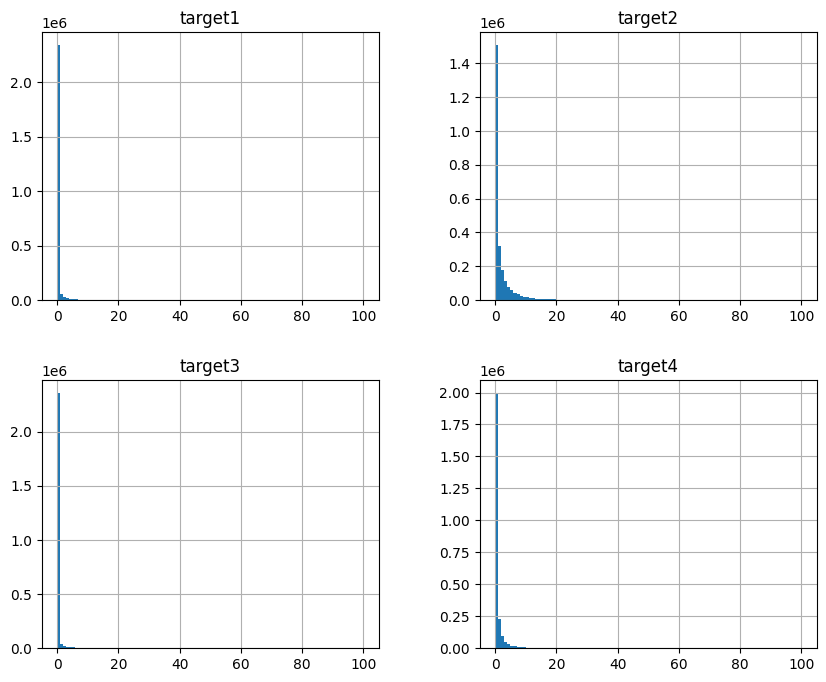

In [6]:
targets[trg_cols].hist(figsize=(10, 8), bins=100);

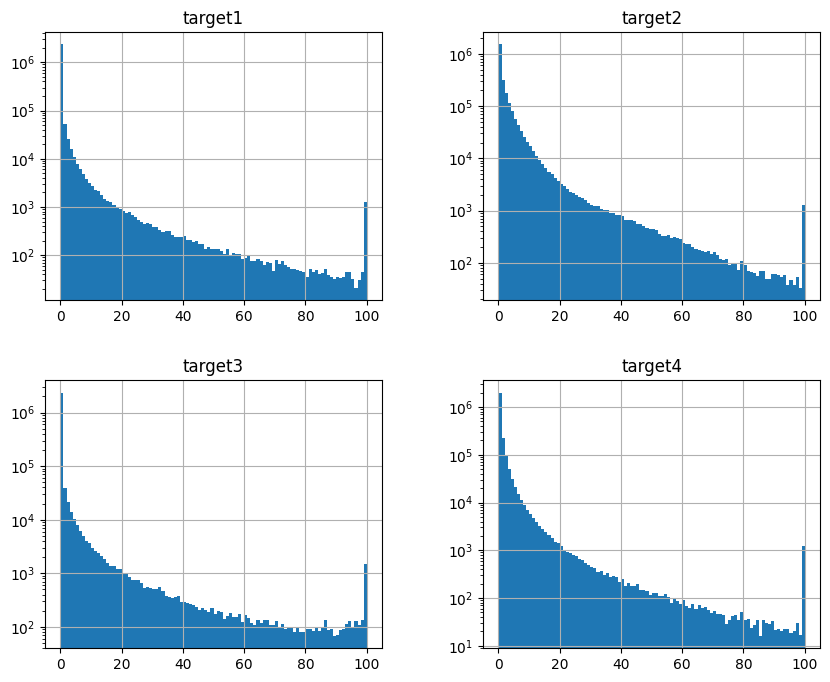

In [7]:
targets[trg_cols].hist(figsize=(10, 8), bins=100, log=True);

---
### Boxplots

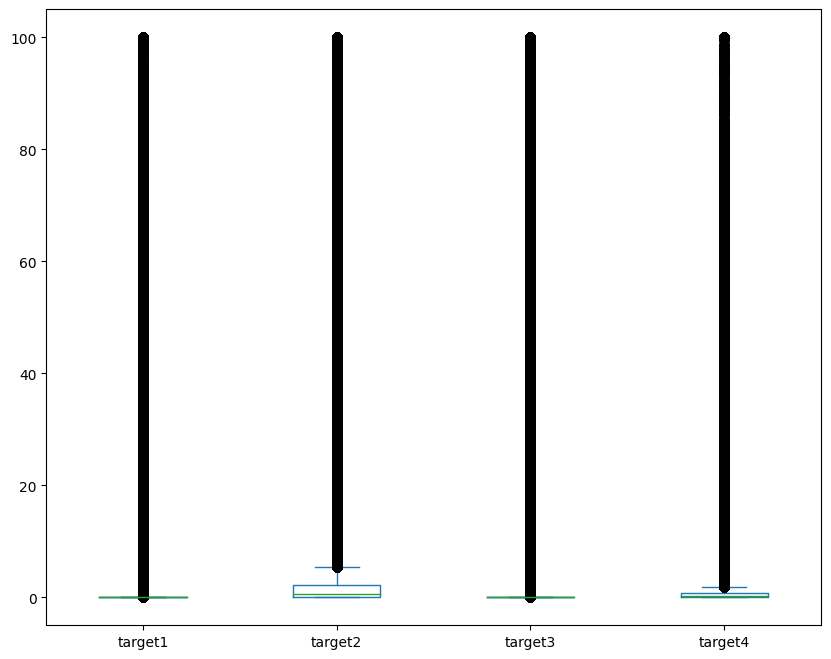

In [8]:
targets[trg_cols].plot(kind='box', figsize=(10, 8));

---
### Correlação

In [9]:
corr = targets[trg_cols].corr()
corr.style.background_gradient(cmap='coolwarm')

,target1,target2,target3,target4
target1,1.000000,0.404532,0.411024,0.384962
target2,0.404532,1.000000,0.388134,0.548991
target3,0.411024,0.388134,1.000000,0.370333
target4,0.384962,0.548991,0.370333,1.000000


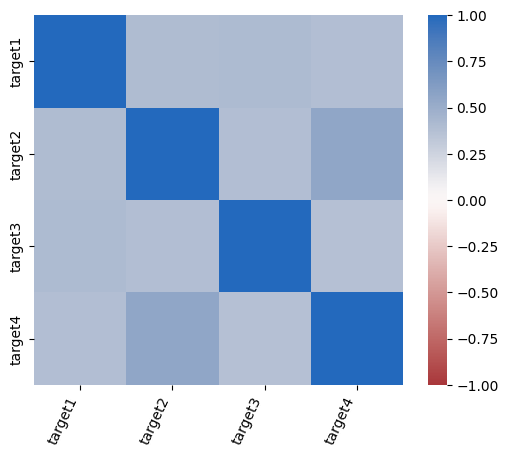

In [10]:
ax = sns.heatmap( corr,
				vmin=-1, vmax=1, center=0,
				cmap='vlag_r', #sns.diverging_palette(20, 220, n=200),
				square=True
)

ax.set_xticklabels(
	ax.get_xticklabels(),
	rotation=65,
	horizontalalignment='right'
);


---
### Scatter

In [17]:
sns.PairGrid(targets[trg_cols], corner=True)\
    .map_lower(sns.scatterplot, alpha = 0.05)\
    .map_diag(sns.scatterplot, alpha = 0.05);

In [12]:
# sns.PairGrid(
#     targets[trg_cols], diag_sharey=False
# ).map_lower(
#     sns.scatterplot
# ).map_upper(
#     sns.kdeplot, levels=4, color=".2"
# ).map_diag(
#     sns.histplot, kde=True, element="step", bins=100
# );

In [13]:
target_means = targets.groupby('Dt').mean()[trg_cols]
target_means.head()

,target1,target2,target3,target4
Dt,,,,
2018-01-01,0.213906,2.889072,1.096593,1.498630
2018-01-02,0.134676,1.656669,0.586616,1.014239
2018-01-03,0.138039,1.703637,0.640385,1.627010
2018-01-04,0.179802,2.010626,0.945296,2.200443
2018-01-05,0.352017,0.936101,0.640302,0.794969


In [14]:
target_means_melted = target_means.melt(var_name='target', value_name='value', ignore_index=False)
target_means_melted.reset_index(inplace=True)
target_means_melted.head()

,Dt,target,value
0,2018-01-01,target1,0.213906
1,2018-01-02,target1,0.134676
2,2018-01-03,target1,0.138039
3,2018-01-04,target1,0.179802
4,2018-01-05,target1,0.352017


KeyError: "None of [Index([(2018-01-01, 2018-01-02, 2018-01-03, 2018-01-04, 2018-01-05, 2018-01-06, 2018-01-07, 2018-01-08, 2018-01-09, 2018-01-10, 2018-01-11, 2018-01-12, 2018-01-13, 2018-01-14, 2018-01-15, 2018-01-16, 2018-01-17, 2018-01-18, 2018-01-19, 2018-01-20, 2018-01-21, 2018-01-22, 2018-01-23, 2018-01-24, 2018-01-25, 2018-01-26, 2018-01-27, 2018-01-28, 2018-01-29, 2018-01-30, 2018-01-31, 2018-02-01, 2018-02-02, 2018-02-03, 2018-02-04, 2018-02-05, 2018-02-06, 2018-02-07, 2018-02-08, 2018-02-09, 2018-02-10, 2018-02-11, 2018-02-12, 2018-02-13, 2018-02-14, 2018-02-15, 2018-02-16, 2018-02-17, 2018-02-18, 2018-02-19, 2018-02-20, 2018-02-21, 2018-02-22, 2018-02-23, 2018-02-24, 2018-02-25, 2018-02-26, 2018-02-27, 2018-02-28, 2018-03-01, 2018-03-02, 2018-03-03, 2018-03-04, 2018-03-05, 2018-03-06, 2018-03-07, 2018-03-08, 2018-03-09, 2018-03-10, 2018-03-11, 2018-03-12, 2018-03-13, 2018-03-14, 2018-03-15, 2018-03-16, 2018-03-17, 2018-03-18, 2018-03-19, 2018-03-20, 2018-03-21, 2018-03-22, 2018-03-23, 2018-03-24, 2018-03-25, 2018-03-26, 2018-03-27, 2018-03-28, 2018-03-29, 2018-03-30, 2018-03-31, 2018-04-01, 2018-04-02, 2018-04-03, 2018-04-04, 2018-04-05, 2018-04-06, 2018-04-07, 2018-04-08, 2018-04-09, 2018-04-10, ...), (0.21390628814697266, 0.1346760243177414, 0.138038769364357, 0.17980226874351501, 0.35201695561408997, 0.18419905006885529, 0.1585206389427185, 0.2533535957336426, 0.28251510858535767, 0.49667999148368835, 0.26744067668914795, 0.2048112004995346, 0.264116495847702, 0.24518869817256927, 0.21937306225299835, 0.22871780395507812, 0.616545557975769, 0.28541579842567444, 0.21847131848335266, 0.14835789799690247, 0.4866752326488495, 0.35212138295173645, 0.5518597960472107, 0.30197155475616455, 0.16615620255470276, 0.18026697635650635, 0.5361425280570984, 0.16584056615829468, 0.1837429255247116, 0.4183380603790283, 0.1034882515668869, 0.13577130436897278, 0.24485842883586884, 0.2422427237033844, 0.15633437037467957, 0.1197732612490654, 0.20156188309192657, 0.16950379312038422, 0.6718828082084656, 0.21125724911689758, 0.11612052470445633, 0.36117929220199585, 0.19115610420703888, 0.20925010740756989, 0.29266247153282166, 0.21540957689285278, 0.17536063492298126, 0.20209801197052002, 0.4353814423084259, 0.27795687317848206, 0.3021237850189209, 0.3821909725666046, 0.5655903220176697, 0.3741397261619568, 0.5100303292274475, 0.327912300825119, 0.39652734994888306, 0.2889248728752136, 0.42706453800201416, 0.3555799722671509, 0.4836942255496979, 0.5938957333564758, 0.44795453548431396, 0.4392784535884857, 0.3103283941745758, 0.3250010013580322, 0.48075032234191895, 0.40615108609199524, 0.4707178473472595, 0.43401476740837097, 0.33090198040008545, 0.427205890417099, 1.0147215127944946, 0.45272788405418396, 0.5246284604072571, 0.7462771534919739, 0.4470643699169159, 0.2969991862773895, 0.429498553276062, 0.4001277685165405, 0.4260242283344269, 0.3933314383029938, 0.4547698199748993, 0.32137393951416016, 0.3991793692111969, 0.3039303421974182, 0.3347635865211487, 0.41666314005851746, 0.46609389781951904, 0.7130377888679504, 0.31241080164909363, 0.4272150695323944, 0.2937426269054413, 0.5226826667785645, 0.4696405231952667, 0.38371214270591736, 0.4906378984451294, 0.487983763217926, 1.0006874799728394, 0.7917157411575317, ...)], dtype='object')] are in the [columns]"

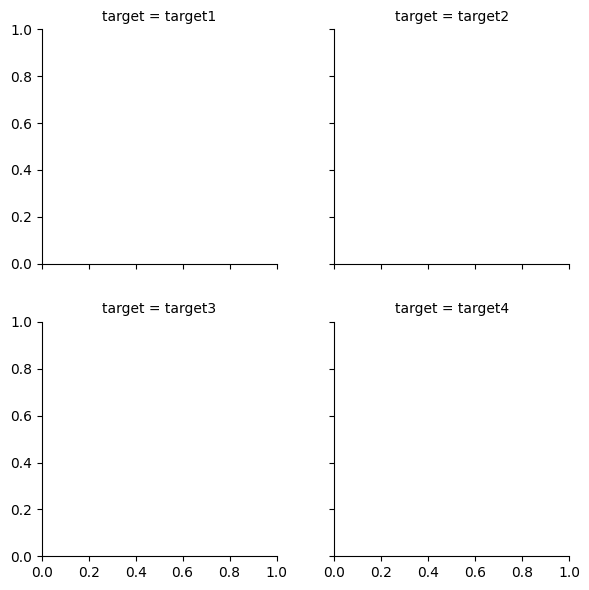

In [15]:
sns.FacetGrid(
    target_means_melted, 
    col='target', 
    col_wrap=2, 
    sharey=True
).map(
    sns.lineplot, 
    target_means_melted['Dt'], 
    target_means_melted['value']
);

In [ ]:
# figure, axes = plt.subplots(2, 2, figsize=(10, 8))
# for i, ax in enumerate(axes.flatten()):
#     sns.lineplot(data=targets, x='Dt', y=trg_cols[i], ax=ax)
#     ax.set_title(trg_cols[i])


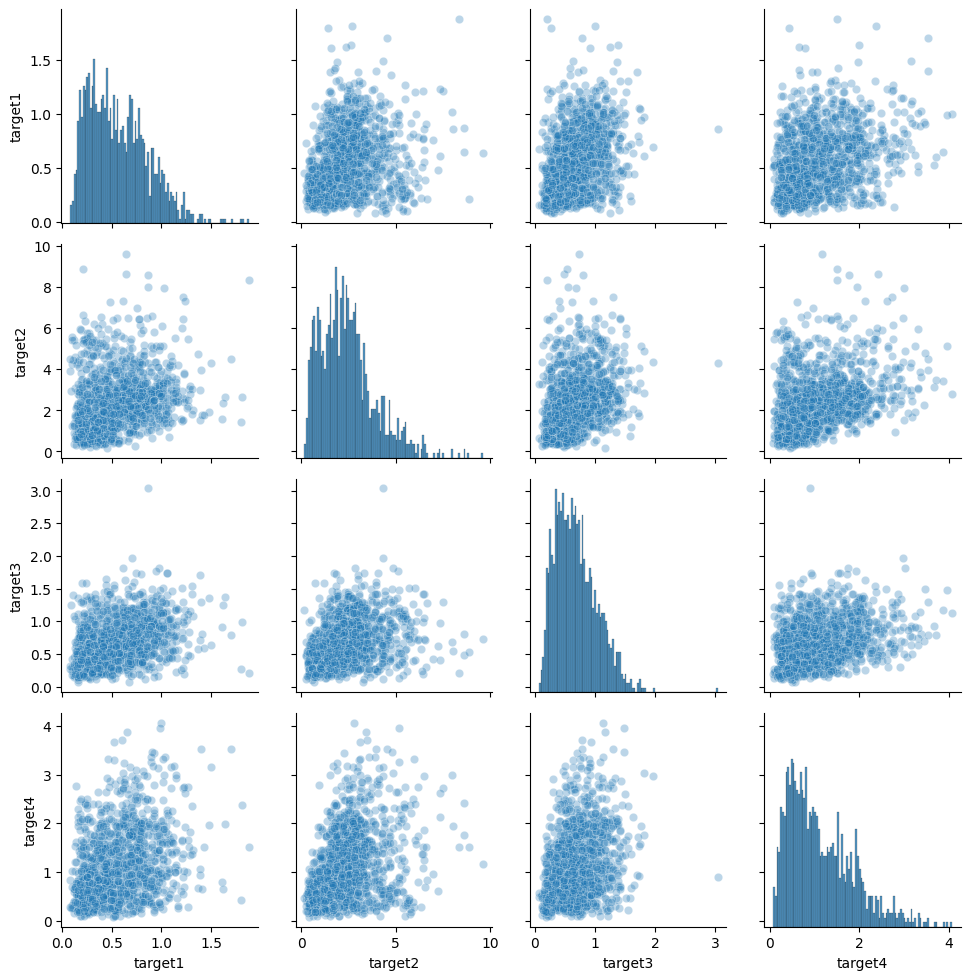

In [ ]:
alpha = 0.3
sns.PairGrid(target_means)\
    .map_lower(sns.scatterplot, alpha = alpha)\
    .map_upper(sns.kdeplot)\
    .map_diag(sns.histplot, bins=100);

### Observações
+ 2 506 176 registros
+ Os targets variam de 0 a 100
+ Média bem próxima de 0
---
+ 1216 dias